![enter image description here](https://img.shields.io/badge/Author-Nestor_Batista_Díaz-yellow)

# <center>CHESS</center>

## IMPORTS

In [1]:
import splitfolders
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
import Augmentor
import shutil

## DATASET

In [2]:
original_path = "Chessman-image-dataset/Chess"
print(os.listdir(original_path))

['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook']


In [3]:
# Esta variable contiene un mapeo de número de clase a piezas de ajedrez.
MAP_PIECE = {
    0: 'Bishop', 1: 'King', 2: 'Knight',
    3: 'Pawn', 4: 'Queen', 5: 'Rook'
}

# Vamos a standarizar todas las imágenes a tamaño 128x128
IMG_SIZE = 128

### LIMPIEZA DE DATOS

In [4]:
# Lista de archivos que deseas excluir
exclude = ["00000176.jpg"]

# Crear una nueva carpeta para los archivos que deseas mantener
keep_folder = "chessman-image-modified"
os.makedirs(keep_folder, exist_ok=True)

# Copiar los archivos que deseas mantener a la nueva carpeta
for label, piece in MAP_PIECE.items():
    path = os.path.join(original_path, piece)
    new_path = keep_folder+"/"+piece
    os.makedirs(new_path, exist_ok= True)
    files = os.listdir(path)
    for file in files:
        if file not in exclude and (file.endswith("jpg") or file.endswith("png") or file.endswith("jpeg") or file.endswith("JPG")):
            shutil.copy(os.path.join(path, file), new_path)

### DIVIDIR EN SPLITS

In [5]:
# dividimos los archivos en tres conjuntos entrenamiento, validación y pruebas
splitfolders.ratio(keep_folder,seed=1337, output="Chess-Splitted", ratio=(0.6, 0.2, 0.2))

Copying files: 550 files [00:08, 62.91 files/s]


### DATA AUGMENTATION

In [6]:
# Aumentamos los datos para tener más datos de entrenamiento
def dataset_aumentation(dirname, map_pieces):
    for label, piece in map_pieces.items():
        p = Augmentor.Pipeline(dirname+"/"+piece, output_directory="")
        # Definir las operaciones de aumento que deseas aplicar
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        p.flip_left_right(probability=0.5)
        p.zoom_random(probability=0.5, percentage_area=0.8)
        p.random_contrast(probability=0.5, min_factor=0.5, max_factor=1.5)
        p.random_brightness(probability=0.5, min_factor=0.5, max_factor=1.5)
        p.random_color(probability=0.5, min_factor=0.5, max_factor=1.5)

        # Especificar cuántas imágenes aumentadas deseas generar
        p.sample(2000)  # Genera 2000 nuevas imágenes

In [7]:
DATASET_TRAIN_PATH = "Chess-Splitted/train"
dataset_aumentation(DATASET_TRAIN_PATH, MAP_PIECE)

Initialised with 51 image(s) found.
Output directory set to Chess-Splitted/train/Bishop\.

Processing <PIL.Image.Image image mode=RGB size=391x879 at 0x200EF91BFD0>: 100%|██████████| 2000/2000 [00:41<00:00, 47.97 Samples/s]                    


Initialised with 45 image(s) found.
Output directory set to Chess-Splitted/train/King\.

Processing <PIL.Image.Image image mode=RGB size=587x900 at 0x200EF96ED50>: 100%|██████████| 2000/2000 [01:48<00:00, 18.47 Samples/s]                  


Initialised with 63 image(s) found.
Output directory set to Chess-Splitted/train/Knight\.

Processing <PIL.Image.Image image mode=RGB size=880x680 at 0x200EF90EFD0>: 100%|██████████| 2000/2000 [00:59<00:00, 33.76 Samples/s]                  


Initialised with 63 image(s) found.
Output directory set to Chess-Splitted/train/Pawn\.

Processing <PIL.Image.Image image mode=RGB size=1920x1080 at 0x200EF5BF310>: 100%|██████████| 2000/2000 [01:03<00:00, 31.45 Samples/s]                  


Initialised with 46 image(s) found.
Output directory set to Chess-Splitted/train/Queen\.

Processing <PIL.Image.Image image mode=RGB size=1000x1080 at 0x200EF862690>: 100%|██████████| 2000/2000 [00:50<00:00, 39.99 Samples/s]                  


Initialised with 61 image(s) found.
Output directory set to Chess-Splitted/train/Rook\.

Processing <PIL.Image.Image image mode=RGB size=400x400 at 0x200EF34FB90>: 100%|██████████| 2000/2000 [00:37<00:00, 53.52 Samples/s]                   


## ENTRENAMIENTO

### CARGAR DATOS

In [8]:
def load_train_set(dirname, map_pieces, verbose=True):
    """Esta función carga los datos de training en imágenes.

    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.

    Args:
        dirname: directorio completo del que leer los datos
        map_pieces: variable de mapeo entre labels y piezas
        verbose: si es True, muestra información de las imágenes cargadas

    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, piece in map_pieces.items():
        files = os.listdir(os.path.join(dirname, piece))
        images = [file for file in files if (file.endswith("jpg") or file.endswith("png") or file.endswith("jpeg") or file.endswith("JPG"))]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), piece))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, piece, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [9]:
def load_test_set(dirname, map_pieces, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    for label, piece in map_pieces.items():
        files = os.listdir(os.path.join(dirname, piece))
        images = [file for file in files if (file.endswith("jpg") or file.endswith("png") or file.endswith("jpeg") or file.endswith("JPG"))]
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, piece, image_name))
            X_test.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_test.append(label)
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)

In [10]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH = "Chess-Splitted/train"
DATASET_TEST_PATH = "Chess-Splitted/test"

X, y = load_train_set(DATASET_TRAIN_PATH, MAP_PIECE)
X_t, y_t = load_test_set(DATASET_TEST_PATH, MAP_PIECE)

Leyendo 2051 imágenes encontradas de Bishop
Leyendo 2045 imágenes encontradas de King
Leyendo 2063 imágenes encontradas de Knight
Leyendo 2063 imágenes encontradas de Pawn
Leyendo 2046 imágenes encontradas de Queen
Leyendo 2061 imágenes encontradas de Rook
Leídas 112 imágenes de test


In [11]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de piezas, ya que
# las imágenes se leen secuencialmente pieza a pieza.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

In [12]:
# Preprocessing normalización de las imágenes
X = X / 255.0
X_t = X_t / 255.0

In [13]:
def visualize_example(x):
  plt.figure()
  plt.imshow(x)
  plt.colorbar()
  plt.grid(False)
  plt.show()

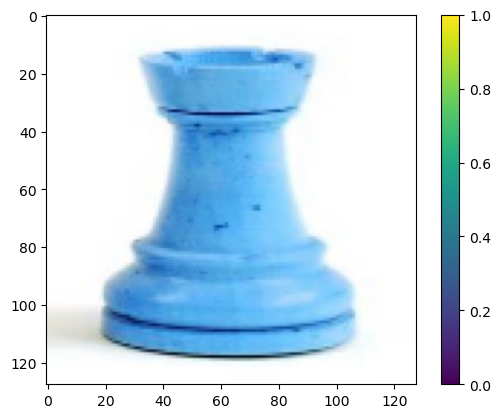

Rook
(128, 128, 3)


In [14]:
visualize_example(X[70]) # Visualiza la imagen normalizada con valores de 0 a 1
print(MAP_PIECE[y[70]]) # Acceso al diccionario
print(X[70].shape[0:3]) # Dimensiones de la imagen tras resize con los 3 canales RGB

In [15]:
#batch_size=128
num_classes=6
epochs=10
img_rows,img_cols=IMG_SIZE,IMG_SIZE
input_shape=(img_rows,img_cols,3) #(128,128,3)

In [16]:
# convert class vectors to binary class matrices
y=keras.utils.to_categorical(y,num_classes)
y_t=keras.utils.to_categorical(y_t,num_classes)

In [17]:
X.shape

(12329, 128, 128, 3)

In [18]:
y.shape

(12329, 6)

### CARGAR MODELO

In [34]:
# Definimos un modelo de red neuronal convolucional para clasificación con varias capas convolucionales, 
# capas de reducción de dimensionalidad, capas densas y regularización para prevenir el sobreajuste 
# durante el entrenamiento.

model = keras.Sequential([
keras.layers.Conv2D(32, kernel_size=(3, 3), data_format="channels_last",input_shape=input_shape, activation='relu'),
keras.layers.MaxPooling2D(pool_size=(2, 2)),
keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
keras.layers.MaxPooling2D(pool_size=(2, 2)),
keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu'),
keras.layers.MaxPooling2D(pool_size=(2, 2)),
keras.layers.MaxPooling2D(pool_size=(2, 2)),
keras.layers.Flatten(),
keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001, l2=0.0001)),
keras.layers.Dropout(0.5),
keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001, l2=0.0001)),
keras.layers.Dense(6, activation='softmax')
])

In [35]:
model.summary()
model.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 61, 61, 128)       36992     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 30, 30, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 512)       590336    
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 14, 14, 512)      

### ENTRENAMIENTO

In [36]:
history=model.fit(X, y, epochs=epochs, validation_split = 0.2)

Epoch 1/10
309/309 [==============================] - 234s 755ms/step - loss: 2.0273 - accuracy: 0.2758 - val_loss: 1.6166 - val_accuracy: 0.4886
Epoch 2/10
309/309 [==============================] - 238s 770ms/step - loss: 1.5557 - accuracy: 0.5253 - val_loss: 1.2871 - val_accuracy: 0.6845
Epoch 3/10
309/309 [==============================] - 243s 788ms/step - loss: 1.2810 - accuracy: 0.6714 - val_loss: 1.0959 - val_accuracy: 0.7693
Epoch 4/10
309/309 [==============================] - 223s 723ms/step - loss: 1.0871 - accuracy: 0.7725 - val_loss: 1.0132 - val_accuracy: 0.8167
Epoch 5/10
309/309 [==============================] - 222s 718ms/step - loss: 0.9883 - accuracy: 0.8207 - val_loss: 0.8383 - val_accuracy: 0.8869
Epoch 6/10
309/309 [==============================] - 229s 743ms/step - loss: 0.8773 - accuracy: 0.8612 - val_loss: 0.7846 - val_accuracy: 0.8974
Epoch 7/10
309/309 [==============================] - 221s 715ms/step - loss: 0.8293 - accuracy: 0.8839 - val_loss: 0.7588 -

## CONCLUSIONES

In [37]:
def plot_acc(history, title="Model Accuracy"):
  """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title(title)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
def plot_loss(history, title="Model Loss"):
  """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()

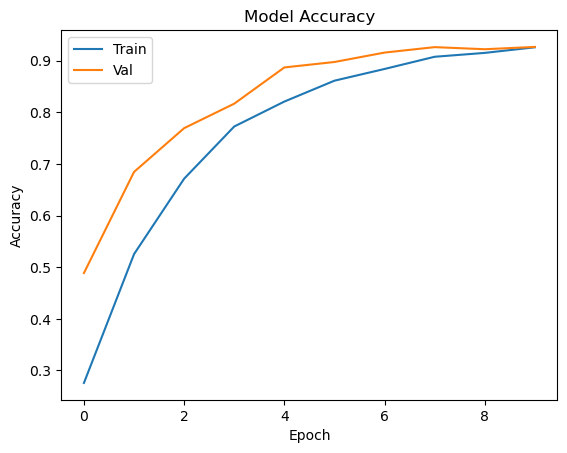

In [38]:
plot_acc(history)

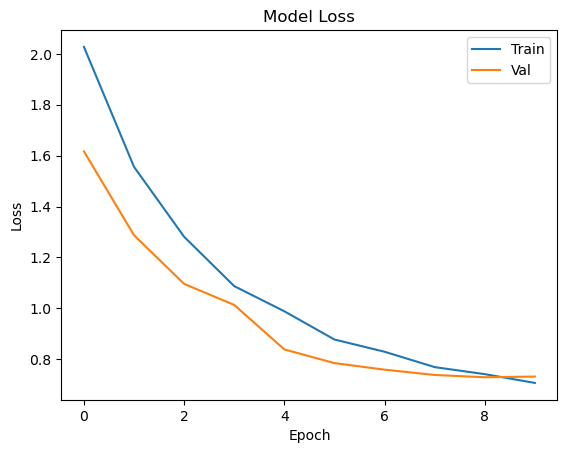

In [39]:
plot_loss(history)

In [40]:
model.evaluate(X_t, y_t, batch_size=32, verbose=1)

4/4 [==============================] - 1s 113ms/step - loss: 2.5377 - accuracy: 0.6161


[2.5377461910247803, 0.6160714030265808]

In [41]:
prediccion=model.predict(X_t, batch_size=32, verbose=1)

4/4 [==============================] - 1s 107ms/step


In [42]:
print(prediccion)
prediccion.shape

[[9.99989986e-01 1.23765449e-06 1.43543982e-10 8.65401717e-07
  7.86538658e-06 1.43995635e-10]
 [9.38722670e-01 2.28202827e-02 8.29503506e-07 1.07248279e-03
  3.73432189e-02 4.05952633e-05]
 [2.00341158e-02 2.91920230e-02 3.47939171e-02 1.05111599e-02
  6.07802570e-02 8.44688535e-01]
 [9.99999762e-01 1.22084472e-07 8.97493207e-14 6.53533476e-08
  5.24970378e-09 6.51895530e-14]
 [3.28495279e-02 6.09984040e-01 2.11439124e-06 3.19181412e-01
  3.78259830e-02 1.56862923e-04]
 [3.64172533e-02 6.48538730e-07 3.65072815e-03 9.58877802e-01
  1.59134254e-06 1.05198740e-03]
 [9.99992490e-01 6.76408990e-06 6.60458830e-14 2.92565744e-07
  4.27681812e-07 7.33346082e-14]
 [9.50592160e-01 1.59057416e-03 2.11506267e-03 3.94361354e-02
  4.49742982e-03 1.76859600e-03]
 [9.99411345e-01 2.27092787e-05 1.88691857e-12 3.64478031e-10
  5.65881142e-04 6.15232344e-12]
 [9.94027019e-01 1.71328807e-07 2.56578359e-09 5.97281335e-03
  3.09671080e-08 1.31139410e-09]
 [9.99990463e-01 4.83158783e-06 1.19194503e-08 3.5

(112, 6)

In [43]:
print(prediccion[0]) # Ejemplo de predicción para el primer elemento del test.
predicho = np.argmax(prediccion[0])  # Nos quedamos con la posición del valor máximo de las estimaciones de probabilidad para cada una de las 6 clases.
print(predicho)
print(MAP_PIECE[predicho]) # Acceso al diccionario para mostrar el nombre de la pieza predicha.

[9.9998999e-01 1.2376545e-06 1.4354398e-10 8.6540172e-07 7.8653866e-06
 1.4399563e-10]
0
Bishop


In [44]:
y_t.shape

(112, 6)

In [45]:
from sklearn.metrics import confusion_matrix, classification_report
LIST_PIECE = ['Bishop','King','Knight','Pawn', 'Queen', 'Rook']
informe = classification_report(np.argmax(y_t,axis=1), np.argmax(prediccion,axis=1), target_names= LIST_PIECE)
print(informe)

              precision    recall  f1-score   support

      Bishop       0.63      0.67      0.65        18
        King       0.45      0.67      0.54        15
      Knight       0.86      0.86      0.86        21
        Pawn       0.67      0.67      0.67        21
       Queen       0.25      0.19      0.21        16
        Rook       0.71      0.57      0.63        21

    accuracy                           0.62       112
   macro avg       0.59      0.60      0.59       112
weighted avg       0.62      0.62      0.61       112



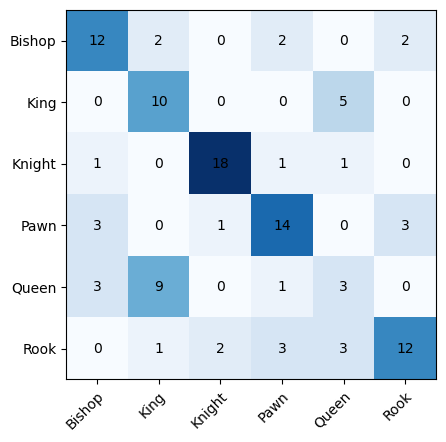

In [46]:
# Calcular la matriz de confusión para clasificación multi-label
matriz_confusion = confusion_matrix(np.argmax(y_t,axis=1), np.argmax(prediccion,axis=1))

# Crear una figura y ejes
fig, ax = plt.subplots()
im = ax.imshow(matriz_confusion, cmap='Blues')

# Mostrar las etiquetas en los ejes
ax.set_xticks(np.arange(len(LIST_PIECE)))
ax.set_yticks(np.arange(len(LIST_PIECE)))
ax.set_xticklabels(LIST_PIECE)
ax.set_yticklabels(LIST_PIECE)

# Rotar las etiquetas y ajustar la posición
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Mostrar los valores en cada celda
for i in range(len(LIST_PIECE)):
    for j in range(len(LIST_PIECE)):
        text = ax.text(j, i, matriz_confusion[i, j], ha="center", va="center", color="black")

plt.show()

Como podemos Observar el modelo confunde la pieza "Queen" con la pieza "King", habria que presentarle más imagenes de estas dos piezas para que pueda
distinguir más facilmente entre ambas.